## ## A/B Testing Part 2  :  Bootstrap resampling 

--------

In [1]:
# ref 
# https://github.com/yennanliu/hackermath/blob/master/Module_2f_ABTesting.ipynb
# https://github.com/omoju/Fundamentals/blob/master/Data/data_Stats_4_ABTesting.ipynb


In [2]:
# Import libraries
from __future__ import absolute_import, division, print_function

# Ignore warnings
import warnings
#warnings.filterwarnings('ignore')

import sys
sys.path.append('tools/')

# OP 
import pandas as pd
import numpy as np
#from scipy import stats
import scipy.stats as st
%matplotlib inline
%pylab inline
import seaborn  as sns 
#import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplt
from matplotlib import pyplot
import matplotlib as mpl
from IPython.display import display

Populating the interactive namespace from numpy and matplotlib


In [3]:

# set plot style
matplotlib.style.use('fivethirtyeight')
matplotlib.rcParams['font.size'] = 12
matplotlib.rcParams['figure.figsize'] = (10,10)

In [4]:
# help func 

def axis_tick_frequency(ax, axis, freq):
    """The frequency of the y axis tick marks
        Attributes
        ----------
        ax: matplotlib axis object
        axis: char eithher 'y' or 'x'
        freq: int, the integer value of which the range moves
    """
    
    if axis == 'y':
        start, end = ax.get_ylim()
        ax.yaxis.set_ticks(np.arange(start, end, freq))
    elif axis == 'x':
        start, end = ax.get_xlim()
        ax.xaxis.set_ticks(np.arange(start, end, freq))
    else:
        raise ValueError('{argument} is not a valid axis object'.format(argument=repr(axis)))
        
        
    
def sample(num_sample, top, with_replacement=False):
    """
    Create a random sample from a table
    
    Attributes
    ---------
    num_sample: int
    top: dataframe
    with_replacement: boolean
    
    Returns a random subset of table index
    """
    df_index = []
    lst = np.arange(0, len(top), 1)

    for i in np.arange(0, num_sample, 1):

        # pick randomly from the whole table
        sample_index = np.random.choice(lst)

        if with_replacement:
            # store index
            df_index.append(sample_index)
        else:
            # remove the choice that was selected
            lst = np.setdiff1d(lst,[sample_index])
            df_index.append(sample_index)
            
    return df_index
    

## 0) Load data

In [14]:
# titanic dataset 
# https://www.kaggle.com/c/titanic/data#

df=pd.read_csv('train.csv')

In [8]:
df.head(1)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.25,NaN,S


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x116924a58>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x116a73240>]], dtype=object)

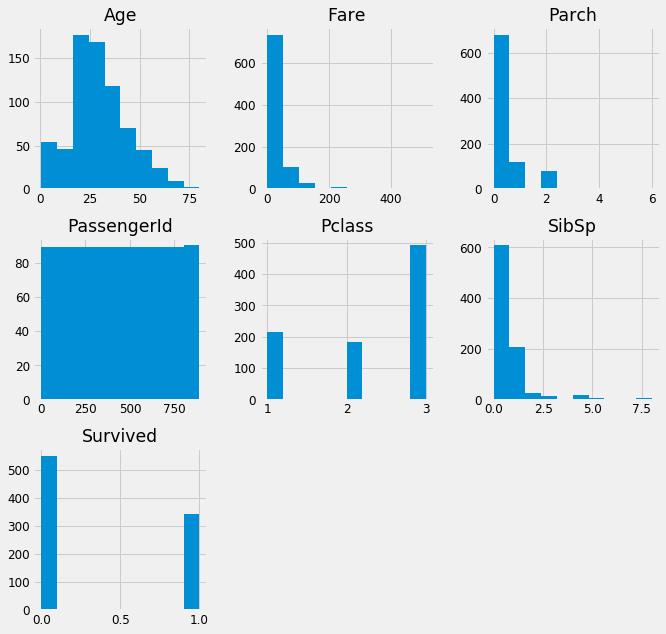

In [9]:
df.hist()

## 1 ) Is "survived or not survived" associated  with Age  ?

In [10]:
df.Survived.value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [13]:
df[df.Survived==1.0 ]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.1000,C123,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.00,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.00,1,0,237736,30.0708,NaN,C
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.00,1,1,PP 9549,16.7000,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.00,0,0,113783,26.5500,C103,S
15,16,1,2,"Hewlett, Mrs. (Mary D Kingcome)",female,55.00,0,0,248706,16.0000,NaN,S
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C


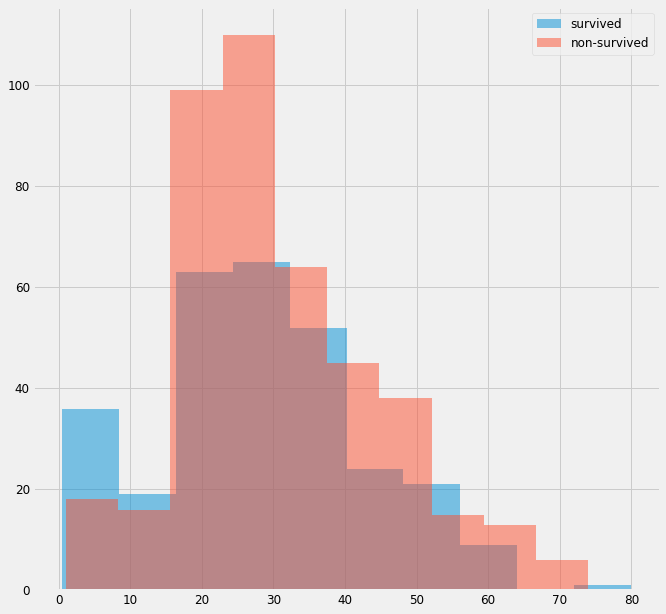

In [20]:
df[df.Survived==1.0 ]['Age'].hist(alpha=.5)
df[df.Survived==0.0 ]['Age'].hist(alpha=.5)
plt.legend(["survived","non-survived" ])